# Tugas 05 : **keyword extraction**

NAMA : M Hasan Basri

NIM  : 2104

MATA KULIAH : Pencarian dan Penambangan Web - A

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import pandas as pd
import numpy as np
import re
import nltk
!pip install Sastrawi
nltk.download('punkt')
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize

import networkx as nx
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/tugasPPWA/Hasil_preprocesing.csv")
df.head()

,judul,tanggal,isi,kategori,cleansing,case_folding,tokenize,Filtering/stopword removal
0,"Labuan Bajo Tak Lepas dari Bahaya Tsunami, BNP...","Rabu, 25 Sep 2024 20:31 WIB","Jakarta - Labuan Bajo, Manggarai Barat, Nusa T...",pariwisata,Jakarta Labuan Bajo Manggarai Barat Nusa Teng...,jakarta labuan bajo manggarai barat nusa teng...,"['jakarta', 'labuan', 'bajo', 'manggarai', 'ba...",jakarta labuan bajo manggarai barat nusa tengg...
1,Kapsul Waktu! Catatan Arkeolog 200 Tahun Lalu ...,"Rabu, 25 Sep 2024 20:05 WIB","Jakarta - Harta karun tak hanya benda saja, ta...",pariwisata,Jakarta Harta karun tak hanya benda saja tapi...,jakarta harta karun tak hanya benda saja tapi...,"['jakarta', 'harta', 'karun', 'tak', 'hanya', ...",jakarta harta karun benda catatan arkeolog lam...
2,Jembatan Ikonik Kota Dunia Ini Kini Hanya Bole...,"Rabu, 25 Sep 2024 19:31 WIB","Jakarta - Ibu kota Prancis, Paris, menjadi per...",pariwisata,Jakarta Ibu kota Prancis Paris menjadi perhat...,jakarta ibu kota prancis paris menjadi perhat...,"['jakarta', 'ibu', 'kota', 'prancis', 'paris',...",jakarta kota prancis paris perhatian dunia men...
3,Pencarian Kapibara Kabur Dihentikan karena Ter...,"Rabu, 25 Sep 2024 19:05 WIB",Jakarta - Kapibara kabur dari kandangnya di Th...,pariwisata,Jakarta Kapibara kabur dari kandangnya di The...,jakarta kapibara kabur dari kandangnya di the...,"['jakarta', 'kapibara', 'kabur', 'dari', 'kand...",jakarta kapibara kabur kandangnya the hoo zoo ...
4,Berburu 'Harta Karun' di Pasar Loak Jatinegara,"Rabu, 25 Sep 2024 19:00 WIB",Jakarta - Pasar Loak Jatinegara atau Jembatan ...,pariwisata,Jakarta Pasar Loak Jatinegara atau Jembatan I...,jakarta pasar loak jatinegara atau jembatan i...,"['jakarta', 'pasar', 'loak', 'jatinegara', 'at...",jakarta pasar loak jatinegara jembatan item pi...


In [39]:
# Mengambil satu sample berita
sample_berita = df['Filtering/stopword removal'].iloc[4]

sample_berita_list = [sample_berita]
print(sample_berita_list)


['jakarta pasar loak jatinegara jembatan item pilihan masyarakat mencari barang kebutuhan berburu barang bekas berkualitas']


In [40]:
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer tanpa batasan jumlah fitur
vectorizer = TfidfVectorizer()

# Fit dan transform teks ke dalam TF-IDF
tfidf_matrix = vectorizer.fit_transform(sample_berita_list)

# Konversi TF-IDF matrix ke DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df.head()

,barang,bekas,berburu,berkualitas,item,jakarta,jatinegara,jembatan,kebutuhan,loak,masyarakat,mencari,pasar,pilihan
0,0.485071,0.242536,0.242536,0.242536,0.242536,0.242536,0.242536,0.242536,0.242536,0.242536,0.242536,0.242536,0.242536,0.242536


In [41]:
# Ubah nilai TF-IDF di bawah 0.5 menjadi 0, dan di atas atau sama dengan 0.5 menjadi 1
df_tfidf_1berita = tfidf_df.apply(lambda col: col.map(lambda x: 1 if x >= 0.03 else 0))

# Menampilkan DataFrame dengan nilai biner
df_tfidf_1berita

,barang,bekas,berburu,berkualitas,item,jakarta,jatinegara,jembatan,kebutuhan,loak,masyarakat,mencari,pasar,pilihan
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [42]:
# Membuat graf berdasarkan co-occurrence fitur
G = nx.Graph()

# Menambahkan node ke graf
for feature in df_tfidf_1berita.columns:
    G.add_node(feature)

# Menambahkan edge berdasarkan co-occurrence
for i in range(len(df_tfidf_1berita)):
    features = df_tfidf_1berita.iloc[i]
    active_features = features[features == 1].index.tolist()

    for j in range(len(active_features)):
        for k in range(j + 1, len(active_features)):
            G.add_edge(active_features[j], active_features[k])

# Hitung degree centrality
degree_centrality = nx.degree_centrality(G)

# Konversi hasil degree centrality ke DataFrame
df_degree_centrality = pd.DataFrame(degree_centrality.items(), columns=['Node', 'Degree Centrality'])

# Mengurutkan DataFrame dari yang terbesar sampai terkecil
df_degree_centrality_sorted = df_degree_centrality.sort_values(by='Degree Centrality', ascending=False)

# Tampilkan hasil degree centrality yang sudah diurutkan
print(df_degree_centrality_sorted)

           Node  Degree Centrality
0        barang                1.0
1         bekas                1.0
2       berburu                1.0
3   berkualitas                1.0
4          item                1.0
5       jakarta                1.0
6    jatinegara                1.0
7      jembatan                1.0
8     kebutuhan                1.0
9          loak                1.0
10   masyarakat                1.0
11      mencari                1.0
12        pasar                1.0
13      pilihan                1.0


In [43]:
# Ambil top 10 fitur dengan degree centrality tertinggi
top_10_features = df_degree_centrality_sorted.head(10)['Node'].tolist()

# DataFrame yang difilter berdasarkan top 10 fitur
filtered_df_train_tfidf = df_tfidf_1berita.copy()

# Tampilkan pesan tentang top 10 fitur yang terpilih
print("\nTop 10 fitur berdasarkan degree centrality:")
print(top_10_features)

# Tampilkan DataFrame asli yang masih memiliki semua fitur
print("\nDataFrame asli dengan semua fitur (tanpa menghapus):")
print(filtered_df_train_tfidf)



Top 10 fitur berdasarkan degree centrality:
['barang', 'bekas', 'berburu', 'berkualitas', 'item', 'jakarta', 'jatinegara', 'jembatan', 'kebutuhan', 'loak']

DataFrame asli dengan semua fitur (tanpa menghapus):
   barang  bekas  berburu  berkualitas  item  jakarta  jatinegara  jembatan  \
0       1      1        1            1     1        1           1         1   

   kebutuhan  loak  masyarakat  mencari  pasar  pilihan  
0          1     1           1        1      1        1  


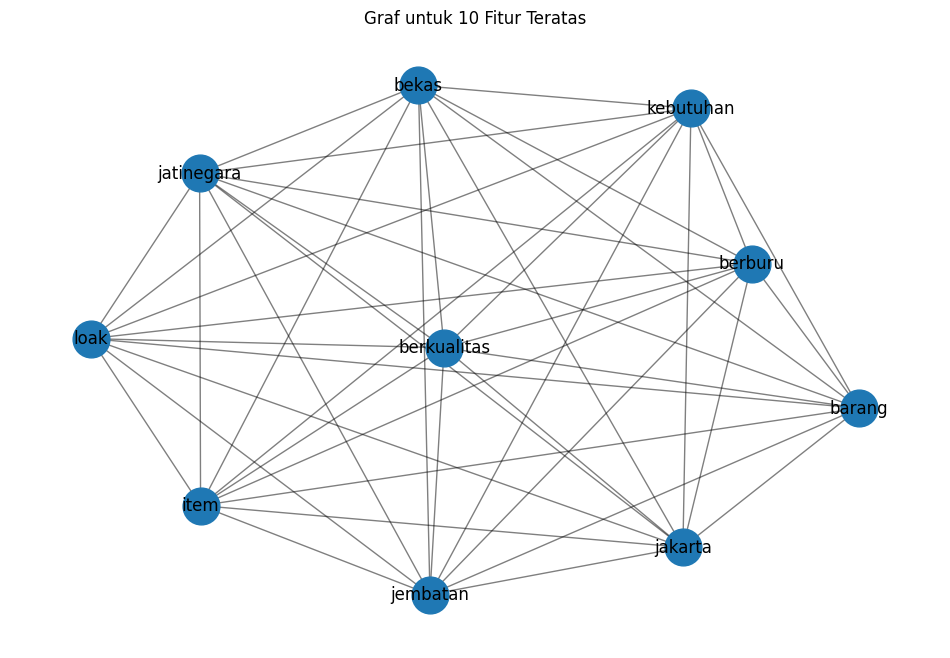

In [44]:
import matplotlib.pyplot as plt
import networkx as nx

# Membuat graf baru hanya untuk fitur teratas
G_top_10 = nx.Graph()

# Menambahkan node teratas ke graf
for feature in top_10_features:
    G_top_10.add_node(feature)

# Pastikan df_tfidf_1berita adalah nama yang benar dari dataframe yang mengandung data biner (TF-IDF)
if 'df_tfidf_1berita' in locals():
    # Menambahkan edge berdasarkan co-occurrence dari fitur teratas
    for i in range(len(df_tfidf_1berita)):
        features = df_tfidf_1berita.iloc[i]
        active_features = features[features == 1].index.tolist()
        active_top_10_features = [f for f in active_features if f in top_10_features]

        for j in range(len(active_top_10_features)):
            for k in range(j + 1, len(active_top_10_features)):
                G_top_10.add_edge(active_top_10_features[j], active_top_10_features[k])

    # Mengatur ukuran figure untuk visualisasi graf
    plt.figure(figsize=(12, 8))

    # Menggambar graf fitur teratas
    pos = nx.spring_layout(G_top_10)
    nx.draw_networkx_nodes(G_top_10, pos, node_size=700)
    nx.draw_networkx_edges(G_top_10, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G_top_10, pos, font_size=12, font_family='sans-serif')

    # Menampilkan graf
    plt.title('Graf untuk 10 Fitur Teratas')
    plt.axis('off')  # Menyembunyikan sumbu
    plt.show()
else:
    print("DataFrame 'df_tfidf_1berita' tidak ditemukan. Pastikan proses TF-IDF sudah dilakukan.")


In [45]:
# Menghitung closeness centrality
closeness_centrality = nx.closeness_centrality(G_top_10)

# Menghitung betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_top_10)

# Konversi hasil centrality ke DataFrame untuk lebih mudah dilihat
df_closeness_centrality = pd.DataFrame(closeness_centrality.items(), columns=['Node', 'Closeness Centrality'])
df_betweenness_centrality = pd.DataFrame(betweenness_centrality.items(), columns=['Node', 'Betweenness Centrality'])

# Menggabungkan semua centrality ke dalam satu DataFrame
df_centrality = pd.merge(df_degree_centrality_sorted, df_closeness_centrality, on='Node')
df_centrality = pd.merge(df_centrality, df_betweenness_centrality, on='Node')

# Menampilkan hasil centrality
print(df_centrality)

          Node  Degree Centrality  Closeness Centrality  \
0       barang                1.0                   1.0   
1        bekas                1.0                   1.0   
2      berburu                1.0                   1.0   
3  berkualitas                1.0                   1.0   
4         item                1.0                   1.0   
5      jakarta                1.0                   1.0   
6   jatinegara                1.0                   1.0   
7     jembatan                1.0                   1.0   
8    kebutuhan                1.0                   1.0   
9         loak                1.0                   1.0   

   Betweenness Centrality  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
5                     0.0  
6                     0.0  
7                     0.0  
8                     0.0  
9                     0.0  


In [46]:
# Mengambil kata kunci dengan nilai TF-IDF tertinggi untuk setiap dokumen
kata_kunci = df_tfidf_1berita.idxmax(axis=1)
print("\nKata kunci dari setiap dokumen:")
for i, kata in enumerate(kata_kunci):
    print(f"Dokumen {i+1}: {kata}")


Kata kunci dari setiap dokumen:
Dokumen 1: barang
